# 02 — Exploratory Analysis

Statistical analysis of all `{{Playlist}}` entries across Utaite Wiki.

**Goal:** Understand format variance, template usage, and identify patterns for parser development.

## Setup

In [1]:
import json
import re
from pathlib import Path
from collections import Counter, defaultdict
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting style
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_RAW = PROJECT_ROOT / "data" / "raw"
MANIFEST_PATH = DATA_RAW / "manifest.json"

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_RAW}")
print(f"Manifest: {MANIFEST_PATH}")

Project root: /home/akkun/utaitewiki-songlist-migration
Data path: /home/akkun/utaitewiki-songlist-migration/data/raw
Manifest: /home/akkun/utaitewiki-songlist-migration/data/raw/manifest.json


## Load Manifest & Basic Stats

In [2]:
# Load manifest
with open(MANIFEST_PATH, 'r', encoding='utf-8') as f:
    manifest = json.load(f)

df = pd.DataFrame(manifest['pages'])

print("=" * 60)
print("COLLECTION SUMMARY")
print("=" * 60)
print(f"Collection date: {manifest['collection_date']}")
print(f"Total pages found: {manifest['total_pages_found']}")
print(f"Excluded: {manifest['excluded_count']}")
print(f"Collected: {manifest['collected_count']}")
print(f"Errors: {len(manifest['errors'])}")
print()
print(f"Total size: {df['size_bytes'].sum() / 1024 / 1024:.1f} MB")
print(f"Unique root artists: {df['root_artist'].nunique()}")
print(f"Subpages (Type 2): {df['is_subpage'].sum()}")
print(f"Monolithic (Type 1): {(~df['is_subpage']).sum()}")

COLLECTION SUMMARY
Collection date: 2026-02-10T10:31:33.173472
Total pages found: 925
Excluded: 0
Collected: 925
Errors: 0

Total size: 11.2 MB
Unique root artists: 911
Subpages (Type 2): 128
Monolithic (Type 1): 797


## Extract All Song Entries

Parse all wikitext files and extract individual song entry lines.

In [3]:
def extract_playlist_entries(wikitext: str) -> list[str]:
    """Extract all # lines from {{Playlist}} blocks."""
    entries = []
    
    # Find all {{Playlist|...}} blocks
    # Using a simple heuristic: lines starting with # inside playlist sections
    in_playlist = False
    for line in wikitext.split('\n'):
        stripped = line.strip()
        
        # Detect playlist start
        if '{{Playlist' in stripped or '{{playlist' in stripped:
            in_playlist = True
        
        # Detect playlist end
        if in_playlist and '}}' in stripped and not stripped.startswith('#'):
            in_playlist = False
        
        # Extract entry lines
        if in_playlist and stripped.startswith('#'):
            # Clean up the line
            clean = stripped.lstrip('#').strip()
            if clean:  # Ignore empty lines
                entries.append(clean)
    
    return entries


# Extract all entries from all pages
all_entries = []
entry_counts_per_page = []

print("Extracting song entries from all pages...")
for i, row in df.iterrows():
    filepath = DATA_RAW / row['filename']
    wikitext = filepath.read_text(encoding='utf-8')
    
    entries = extract_playlist_entries(wikitext)
    entry_counts_per_page.append(len(entries))
    
    for entry in entries:
        all_entries.append({
            'raw_line': entry,
            'source_page': row['title'],
            'root_artist': row['root_artist'],
            'namespace': row['namespace'],
        })
    
    if (i + 1) % 100 == 0:
        print(f"  Processed {i+1}/{len(df)} pages...")

df['entry_count'] = entry_counts_per_page
entries_df = pd.DataFrame(all_entries)

print(f"\n✅ Extracted {len(entries_df):,} total song entries")
print(f"   Average per page: {entries_df.groupby('source_page').size().mean():.1f}")
print(f"   Median per page: {entries_df.groupby('source_page').size().median():.0f}")

Extracting song entries from all pages...
  Processed 100/925 pages...
  Processed 200/925 pages...
  Processed 300/925 pages...
  Processed 400/925 pages...
  Processed 500/925 pages...
  Processed 600/925 pages...
  Processed 700/925 pages...
  Processed 800/925 pages...
  Processed 900/925 pages...

✅ Extracted 81,542 total song entries
   Average per page: 91.9
   Median per page: 70


## Priority 1: Total Pages Transcluding {{Playlist}}

In [4]:
print("=" * 60)
print("PRIORITY 1: Total Pages with {{Playlist}}")
print("=" * 60)
print(f"Total pages: {len(df)}")
print()
print("Breakdown by namespace:")
for ns, count in df['namespace'].value_counts().items():
    ns_name = {0: 'Main', 14: 'Category'}.get(ns, f'ns={ns}')
    print(f"  {ns_name} (ns={ns}): {count} pages ({count/len(df)*100:.1f}%)")
print()
print("Breakdown by page type:")
print(f"  Monolithic (Type 1): {(~df['is_subpage']).sum()} pages")
print(f"  Subpaged (Type 2): {df['is_subpage'].sum()} pages")

PRIORITY 1: Total Pages with {{Playlist}}
Total pages: 925

Breakdown by namespace:
  Main (ns=0): 891 pages (96.3%)
  Category (ns=14): 34 pages (3.7%)

Breakdown by page type:
  Monolithic (Type 1): 797 pages
  Subpaged (Type 2): 128 pages


## Priority 2: Distribution of Song Entry Count Per Page

In [5]:
print("=" * 60)
print("PRIORITY 2: Song Entry Distribution")
print("=" * 60)
print(df['entry_count'].describe())
print()
print(f"Total entries: {df['entry_count'].sum():,}")
print()
print("Top 10 pages by entry count:")
top10 = df.nlargest(10, 'entry_count')[['title', 'root_artist', 'entry_count']]
print(top10.to_string(index=False))

PRIORITY 2: Song Entry Distribution
count    925.000000
mean      88.153514
std       87.778279
min        0.000000
25%       22.000000
50%       66.000000
75%      128.000000
max      746.000000
Name: entry_count, dtype: float64

Total entries: 81,542

Top 10 pages by entry count:
                                                            title root_artist  entry_count
                                                    Hanatan/Songs     Hanatan          746
Hanatan/Songs/Covers on YouTube Livestreams and TwitCasting Lives     Hanatan          639
                                                   Kanipan./Songs    Kanipan.          558
                                                  Uratanuki/Songs   Uratanuki          496
                                                  Meramipop/Songs   Meramipop          485
                                                           Rachie      Rachie          433
                                                     Akatin/Songs      Akatin   

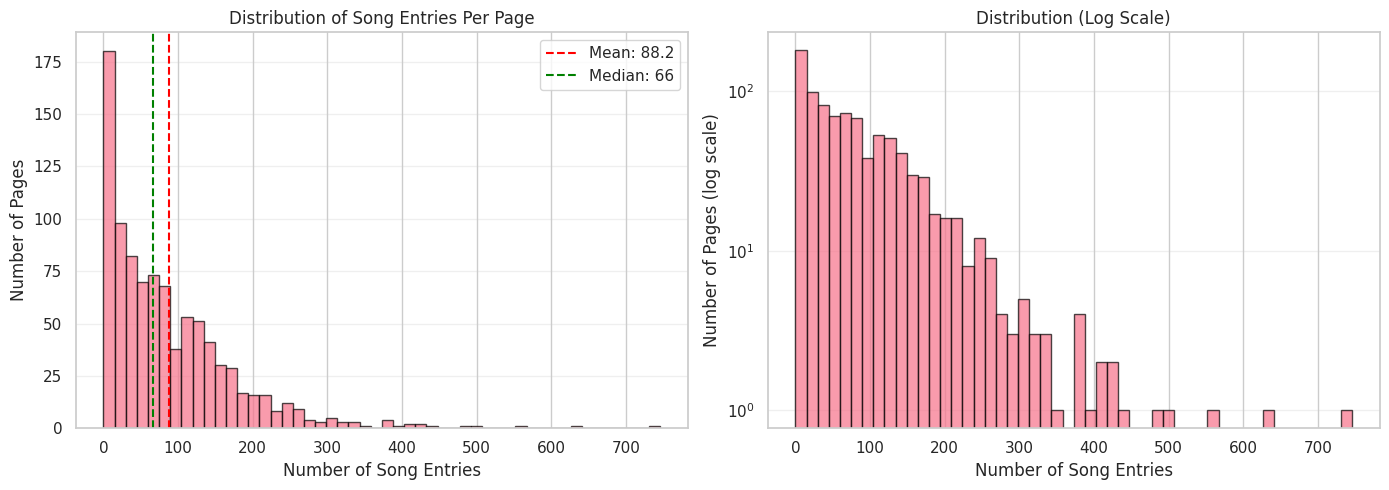

In [6]:
# Histogram of entry counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
ax1.hist(df['entry_count'], bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(df['entry_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["entry_count"].mean():.1f}')
ax1.axvline(df['entry_count'].median(), color='green', linestyle='--', label=f'Median: {df["entry_count"].median():.0f}')
ax1.set_xlabel('Number of Song Entries')
ax1.set_ylabel('Number of Pages')
ax1.set_title('Distribution of Song Entries Per Page')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Log scale for better visibility
ax2.hist(df['entry_count'], bins=50, edgecolor='black', alpha=0.7, log=True)
ax2.set_xlabel('Number of Song Entries')
ax2.set_ylabel('Number of Pages (log scale)')
ax2.set_title('Distribution (Log Scale)')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Priority 3: Regex Match Rate for Standard Patterns

In [7]:
# Define standard pattern regex
STANDARD_PATTERN = re.compile(
    r'^"([^"]+)"'  # Title in quotes
    r'.*?'  # Optional content (feat, version, etc.)
    r'(?:{{yt\|([^}]+)}})?'  # Optional YouTube template
    r'(?:{{nnd\|([^}]+)}})?'  # Optional NND template
    r'.*?'  # Optional content
    r'\((\d{4}\.\d{2}\.\d{2})\)'  # Date in YYYY.MM.DD
)

# Test pattern matching
entries_df['matches_standard'] = entries_df['raw_line'].apply(
    lambda x: bool(STANDARD_PATTERN.search(x))
)

match_rate = entries_df['matches_standard'].sum() / len(entries_df) * 100

print("=" * 60)
print("PRIORITY 3: Regex Match Rate")
print("=" * 60)
print(f"Total entries: {len(entries_df):,}")
print(f"Matches standard pattern: {entries_df['matches_standard'].sum():,} ({match_rate:.1f}%)")
print(f"Non-standard entries: {(~entries_df['matches_standard']).sum():,} ({100-match_rate:.1f}%)")
print()
print("Sample standard matches:")
for entry in entries_df[entries_df['matches_standard']]['raw_line'].sample(5).values:
    print(f"  ✓ {entry[:80]}...")
print()
print("Sample non-standard entries:")
for entry in entries_df[~entries_df['matches_standard']]['raw_line'].sample(5).values:
    print(f"  ✗ {entry[:80]}...")

PRIORITY 3: Regex Match Rate
Total entries: 81,542
Matches standard pattern: 78,003 (95.7%)
Non-standard entries: 3,539 (4.3%)

Sample standard matches:
  ✓ "Inochi no Tabekata" {{yt|U7L-3VXAkSA}} (2020.05.22)...
  ✓ "Memeshikute" {{nnd|sm12690851}} (2010.11.08)...
  ✓ "Sasanqua" {{yt|QtdOkonJolo}} -English ver.- feat. JoyDreamer and [[Nansu]] (201...
  ✓ "Alone in the Rain" {{yt|Pl-A5YcBC0U}} (2013.05.16) {{Privated media}}...
  ✓ "Ai Kotoba" {{nnd|sm15448791}} (Love Words) (2011.08.29)...

Sample non-standard entries:
  ✗ "Idol" (2024.07.26 Singing Stream {{yt|474EJ6GFD9Q}})...
  ✗ "[https://soundcloud.com/marie-fd/fanub-the-reluctant-heroes The reluctant Heroe...
  ✗ "Dilemma" {{yt|637xdGPOMnQ}}...
  ✗ "'''Irony''' {{nnd|sm18635953}} -English ver.- feat. [[Ashe]] and [[RO☆D]] (2012...
  ✗ "" {{nnd|sm36981268}} (2020.06.05)...


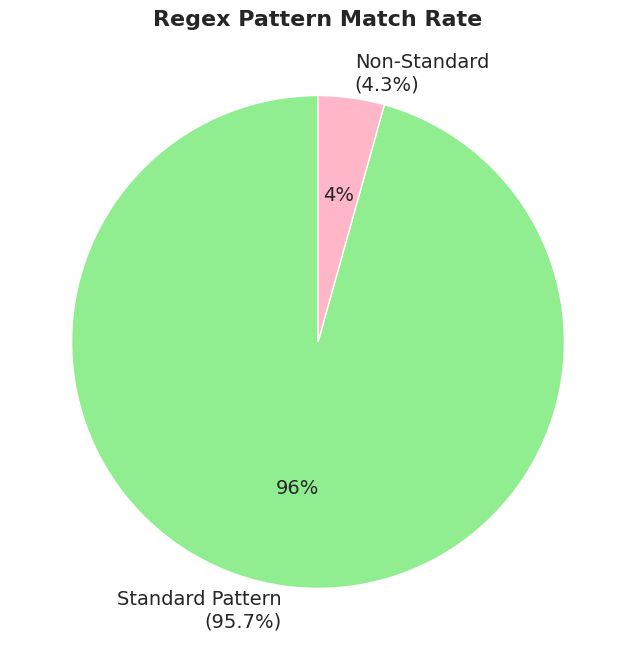

In [8]:
# Pie chart of match rate
fig, ax = plt.subplots(figsize=(8, 8))
sizes = [entries_df['matches_standard'].sum(), (~entries_df['matches_standard']).sum()]
labels = [f'Standard Pattern\n({match_rate:.1f}%)', f'Non-Standard\n({100-match_rate:.1f}%)']
colors = ['#90EE90', '#FFB6C6']
ax.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
ax.set_title('Regex Pattern Match Rate', fontsize=16, fontweight='bold')
plt.show()

## Priority 4: Variant Catalogue (Non-Standard Lines)

In [10]:
non_standard = entries_df[~entries_df['matches_standard']]['raw_line']

print("=" * 60)
print("PRIORITY 4: Non-Standard Entry Variants")
print("=" * 60)
print(f"Total non-standard entries: {len(non_standard):,}")
print()

# Cluster variants by common patterns
variant_patterns = {
    'No quotes': non_standard.apply(lambda x: not x.startswith('"')).sum(),
    'No date': non_standard.apply(lambda x: not re.search(r'\(\d{4}\.\d{2}\.\d{2}\)', x)).sum(),
    'No video link': non_standard.apply(lambda x: '{{yt|' not in x and '{{nnd|' not in x).sum(),
    'Has {{Privated media}}': non_standard.apply(lambda x: '{{Privated media' in x or '{{privated media' in x).sum(),
    'Has {{Deleted media}}': non_standard.apply(lambda x: '{{Deleted media' in x or '{{deleted media' in x).sum(),
    'Has {{Orikyoku}}': non_standard.apply(lambda x: '{{Orikyoku' in x or '{{orikyoku' in x).sum(),
    'Contains note/parody': non_standard.apply(lambda x: 'Parody' in x or 'parody' in x or '[' in x).sum(),
    'Different date format': non_standard.apply(lambda x: bool(re.search(r'\d{4}[/-]\d{1,2}[/-]\d{1,2}', x)) and not re.search(r'\d{4}\.\d{2}\.\d{2}', x)).sum(),
}

print("Common non-standard patterns:")
for pattern, count in sorted(variant_patterns.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(non_standard) * 100
    print(f"  {pattern}: {count:,} ({pct:.1f}%)")

print()
print("Sample non-standard entries (showing first 20):")
for i, entry in enumerate(non_standard.head(20).values, 1):
    print(f"{i:2}. {entry[:100]}..." if len(entry) > 100 else f"{i:2}. {entry}")

PRIORITY 4: Non-Standard Entry Variants
Total non-standard entries: 3,539

Common non-standard patterns:
  No date: 3,069 (86.7%)
  Contains note/parody: 1,473 (41.6%)
  No video link: 907 (25.6%)
  No quotes: 701 (19.8%)
  Has {{Orikyoku}}: 131 (3.7%)
  Different date format: 18 (0.5%)
  Has {{Privated media}}: 13 (0.4%)
  Has {{Deleted media}}: 5 (0.1%)

Sample non-standard entries (showing first 20):
 1. "Wanderlast" {{yt|2rSKJ-8vtOQ}} 2010.01.13
 2. "only my railgun" {{nnd|1268638886}} (15.03.2010) '''(Community only)'''
 3. "[https://creators.yahoo.co.jp/nero/0300040356 Hanabi] (J Soul Brothers) (2019.10.14)  '''(defunct l...
 4. "Hakamairi" {{yt|QJcKdHbWXWg}} (Grave Visiting) (20XX.XX.XX)
 5. "Matryoshka" {{yt|YEbZfYgk8n4}} {{nnd|sm11950227}} (2010.08.31.2010)
 6. "Kinyoubi no Ohayou {{nnd|sm26330665}} (Friday's Good Morning) (2015.05.24)
 7. "Lily Lily★Burning Night {{nnd|sm12239570}} (2010.09.26)
 8. "
 9. "Aishite" {{nnd|sm28413105}} (Love You) (201.03.13)
10. "Just Be Friends

## Priority 5: Template Usage Frequency

In [ ]:
# Count template usage
templates = {
    '{{yt}}': entries_df['raw_line'].str.contains(r'{{yt\|', case=False).sum(),
    '{{nnd}}': entries_df['raw_line'].str.contains(r'{{nnd\|', case=False).sum(),
    '{{feat}}': entries_df['raw_line'].str.contains(r'{{feat\|', case=False).sum(),
    '{{Orikyoku}}': entries_df['raw_line'].str.contains(r'{{Orikyoku', case=False).sum(),
    '{{Privated media}}': entries_df['raw_line'].str.contains(r'{{Privated media', case=False).sum(),
}

print("=" * 60)
print("PRIORITY 5: Template Usage Frequency")
print("=" * 60)
for template, count in sorted(templates.items(), key=lambda x: x[1], reverse=True):
    pct = count / len(entries_df) * 100
    print(f"{template:20} {count:>7,} ({pct:>5.1f}%)")

PRIORITY 5: Template Usage Frequency
{{yt}}                53,905 ( 66.1%)
{{nnd}}               37,032 ( 45.4%)
{{feat}}               3,559 (  4.4%)
{{Orikyoku}}           2,566 (  3.1%)
{{Privated media}}       293 (  0.4%)


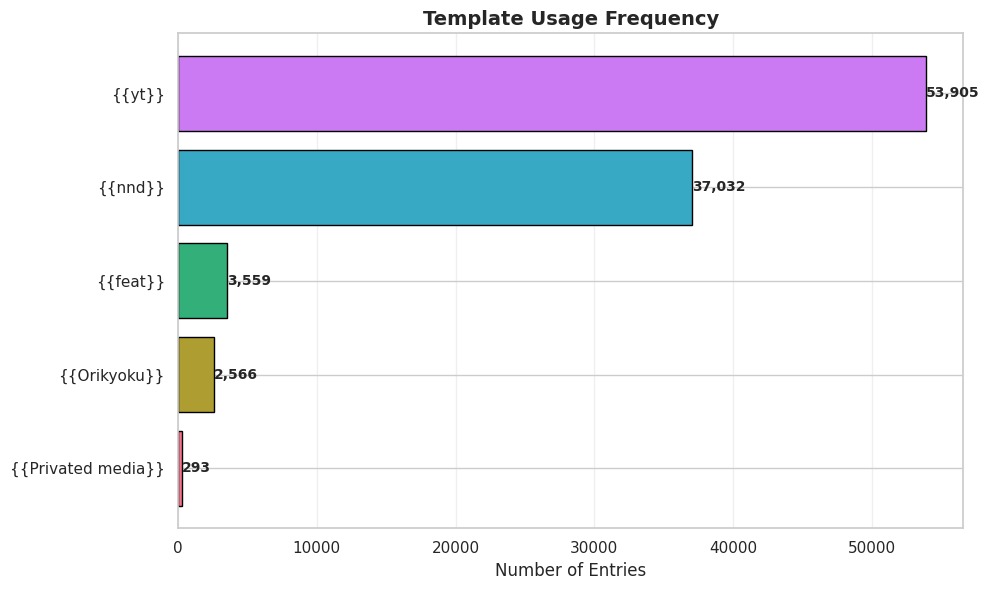

In [15]:
sorted_templates = sorted(templates.items(), key=lambda x: x[1], reverse=False)
fig, ax = plt.subplots(figsize=(10, 6))
template_names = [t[0] for t in sorted_templates]
template_counts = [t[1] for t in sorted_templates]
colors_bar = sns.color_palette("husl", len(template_names))

bars = ax.barh(template_names, template_counts, color=colors_bar, edgecolor='black')
ax.set_xlabel('Number of Entries')
ax.set_title('Template Usage Frequency', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{int(width):,}', 
            ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Priority 6: Platform Distribution

In [16]:
# Classify by platform
entries_df['has_yt'] = entries_df['raw_line'].str.contains(r'{{yt\|', case=False)
entries_df['has_nnd'] = entries_df['raw_line'].str.contains(r'{{nnd\|', case=False)

platform_counts = {
    'YouTube only': (entries_df['has_yt'] & ~entries_df['has_nnd']).sum(),
    'NicoNico only': (~entries_df['has_yt'] & entries_df['has_nnd']).sum(),
    'Both platforms': (entries_df['has_yt'] & entries_df['has_nnd']).sum(),
    'Neither (no video link)': (~entries_df['has_yt'] & ~entries_df['has_nnd']).sum(),
}

print("=" * 60)
print("PRIORITY 6: Platform Distribution")
print("=" * 60)
for platform, count in platform_counts.items():
    pct = count / len(entries_df) * 100
    print(f"{platform:25} {count:>7,} ({pct:>5.1f}%)")

PRIORITY 6: Platform Distribution
YouTube only               36,907 ( 45.3%)
NicoNico only              20,034 ( 24.6%)
Both platforms             16,998 ( 20.8%)
Neither (no video link)     7,603 (  9.3%)


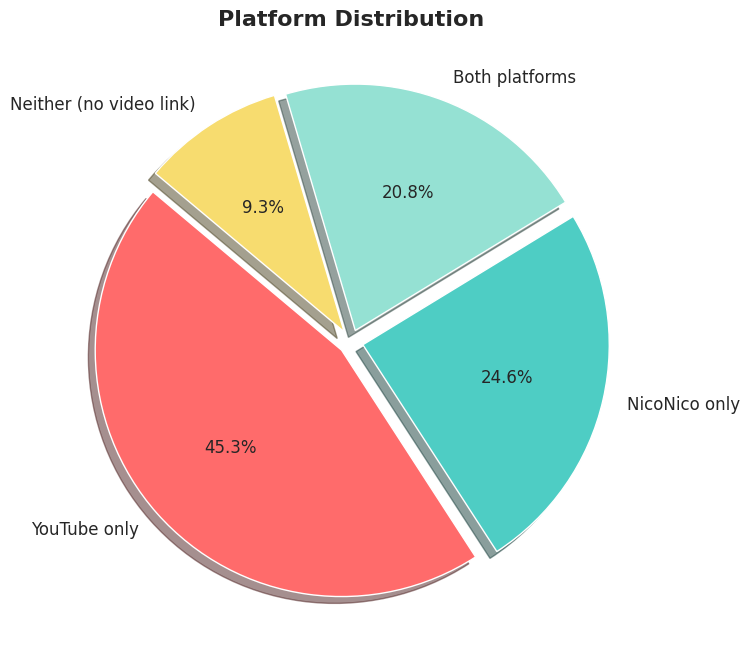

In [17]:
# Pie chart of platform distribution
fig, ax = plt.subplots(figsize=(10, 8))
labels = list(platform_counts.keys())
sizes = list(platform_counts.values())
colors_pie = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#F7DC6F']
explode = (0.05, 0.05, 0.05, 0.05)

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors_pie, 
       explode=explode, shadow=True, textprops={'fontsize': 12})
ax.set_title('Platform Distribution', fontsize=16, fontweight='bold')
plt.show()

## Priority 7: Date Format Analysis

In [18]:
# Extract date patterns
date_patterns = {
    'YYYY.MM.DD': r'\(\d{4}\.\d{2}\.\d{2}\)',
    'YYYY-MM-DD': r'\(\d{4}-\d{2}-\d{2}\)',
    'YYYY/MM/DD': r'\(\d{4}/\d{2}/\d{2}\)',
    'YYYY.M.D (no padding)': r'\(\d{4}\.\d{1,2}\.\d{1,2}\)',
}

date_format_counts = {}
for fmt, pattern in date_patterns.items():
    count = entries_df['raw_line'].str.contains(pattern, case=False).sum()
    date_format_counts[fmt] = count

has_any_date = entries_df['raw_line'].str.contains(r'\d{4}[./-]\d{1,2}[./-]\d{1,2}').sum()
no_date = len(entries_df) - has_any_date

print("=" * 60)
print("PRIORITY 7: Date Format Analysis")
print("=" * 60)
print(f"Entries with date: {has_any_date:,} ({has_any_date/len(entries_df)*100:.1f}%)")
print(f"Entries without date: {no_date:,} ({no_date/len(entries_df)*100:.1f}%)")
print()
print("Date format breakdown:")
for fmt, count in sorted(date_format_counts.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        pct = count / has_any_date * 100 if has_any_date > 0 else 0
        print(f"  {fmt:25} {count:>7,} ({pct:>5.1f}% of dated entries)")

PRIORITY 7: Date Format Analysis
Entries with date: 80,202 (98.4%)
Entries without date: 1,340 (1.6%)

Date format breakdown:
  YYYY.M.D (no padding)      78,598 ( 98.0% of dated entries)
  YYYY.MM.DD                 78,473 ( 97.8% of dated entries)
  YYYY-MM-DD                     14 (  0.0% of dated entries)


## Priority 8: Status Marker Frequency

In [19]:
# Count status markers
status_markers = {
    "'''(Deleted)'''": entries_df['raw_line'].str.contains(r"'''\(Deleted\)'''", case=False).sum(),
    "'''(Private)'''": entries_df['raw_line'].str.contains(r"'''\(Private\)'''", case=False).sum(),
    "'''(Privated)'''": entries_df['raw_line'].str.contains(r"'''\(Privated\)'''", case=False).sum(),
    "'''(Community Only)'''": entries_df['raw_line'].str.contains(r"'''\(Community Only\)'''", case=False).sum(),
    "'''(Unlisted)'''": entries_df['raw_line'].str.contains(r"'''\(Unlisted\)'''", case=False).sum(),
    '{{Privated media}}': entries_df['raw_line'].str.contains(r'{{Privated media', case=False).sum(),
}

total_with_status = sum(status_markers.values())

print("=" * 60)
print("PRIORITY 8: Status Marker Frequency")
print("=" * 60)
print(f"Entries with status markers: {total_with_status:,} ({total_with_status/len(entries_df)*100:.1f}%)")
print()
print("Breakdown by status:")
for marker, count in sorted(status_markers.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        pct = count / len(entries_df) * 100
        print(f"  {marker:25} {count:>6,} ({pct:>4.1f}%)")

PRIORITY 8: Status Marker Frequency
Entries with status markers: 1,734 (2.1%)

Breakdown by status:
  '''(Deleted)'''              862 ( 1.1%)
  '''(Private)'''              294 ( 0.4%)
  {{Privated media}}           293 ( 0.4%)
  '''(Community Only)'''       262 ( 0.3%)
  '''(Unlisted)'''              14 ( 0.0%)
  '''(Privated)'''               9 ( 0.0%)


## Priority 9: Featured Artist Frequency

In [20]:
# Count {{feat|...}} occurrences
def count_feat_templates(line: str) -> int:
    """Count number of {{feat|...}} templates in a line."""
    return len(re.findall(r'{{feat\|', line, re.IGNORECASE))

entries_df['feat_count'] = entries_df['raw_line'].apply(count_feat_templates)
entries_with_feat = entries_df[entries_df['feat_count'] > 0]

print("=" * 60)
print("PRIORITY 9: Featured Artist Frequency")
print("=" * 60)
print(f"Entries with featured artists: {len(entries_with_feat):,} ({len(entries_with_feat)/len(entries_df)*100:.1f}%)")
print()
print("Distribution of featured artist count:")
feat_dist = entries_df['feat_count'].value_counts().sort_index()
for count, freq in feat_dist.items():
    if count > 0:
        pct = freq / len(entries_df) * 100
        print(f"  {count} featured artist(s): {freq:>6,} entries ({pct:>4.1f}%)")
print()
print(f"Max featured artists in a single entry: {entries_df['feat_count'].max()}")
print()
print("Sample entries with multiple featured artists:")
multi_feat = entries_with_feat[entries_with_feat['feat_count'] >= 3].sample(min(5, len(entries_with_feat[entries_with_feat['feat_count'] >= 3])))
for _, row in multi_feat.iterrows():
    print(f"  [{row['feat_count']} feat] {row['raw_line'][:80]}...")

PRIORITY 9: Featured Artist Frequency
Entries with featured artists: 3,559 (4.4%)

Distribution of featured artist count:
  1 featured artist(s):  1,068 entries ( 1.3%)
  2 featured artist(s):  1,554 entries ( 1.9%)
  3 featured artist(s):    252 entries ( 0.3%)
  4 featured artist(s):     81 entries ( 0.1%)
  5 featured artist(s):     97 entries ( 0.1%)
  6 featured artist(s):    141 entries ( 0.2%)
  7 featured artist(s):     58 entries ( 0.1%)
  8 featured artist(s):     54 entries ( 0.1%)
  9 featured artist(s):     25 entries ( 0.0%)
  10 featured artist(s):     25 entries ( 0.0%)
  11 featured artist(s):     14 entries ( 0.0%)
  12 featured artist(s):     16 entries ( 0.0%)
  13 featured artist(s):     10 entries ( 0.0%)
  14 featured artist(s):     21 entries ( 0.0%)
  15 featured artist(s):      4 entries ( 0.0%)
  16 featured artist(s):      9 entries ( 0.0%)
  17 featured artist(s):      2 entries ( 0.0%)
  18 featured artist(s):      1 entries ( 0.0%)
  20 featured artist(s)

## Priority 10: Entry Complexity Score

In [21]:
def calculate_complexity(line: str) -> int:
    """Calculate complexity score for an entry.
    
    Factors:
    - Has quotes: 0 (standard)
    - No quotes: +2
    - Has date: 0
    - No date: +2
    - Has video link: 0
    - No video link: +1
    - Each {{feat}}: +1
    - Has version marker: +1
    - Has status marker: +1
    - Has {{Privated media}}: +2
    - Has {{Orikyoku}}: +1
    - Has parenthetical notes: +1 each
    - Has wikilinks [[...]]: +1 per link
    """
    score = 0
    
    # Quotes
    if not line.startswith('"'):
        score += 2
    
    # Date
    if not re.search(r'\d{4}[./-]\d{1,2}[./-]\d{1,2}', line):
        score += 2
    
    # Video link
    if '{{yt|' not in line.lower() and '{{nnd|' not in line.lower():
        score += 1
    
    # Featured artists
    score += len(re.findall(r'{{feat\|', line, re.IGNORECASE))
    
    # Version marker
    if re.search(r'-[^-]+ ver\.-', line, re.IGNORECASE):
        score += 1
    
    # Status markers
    if re.search(r"'''\([^)]+\)'''", line):
        score += 1
    
    # Special templates
    if '{{Privated media' in line or '{{privated media' in line:
        score += 2
    if '{{Orikyoku' in line or '{{orikyoku' in line:
        score += 1
    
    # Parenthetical notes (excluding date)
    parens = len(re.findall(r'\([^)]*\)', line))
    if re.search(r'\d{4}[./-]\d{1,2}[./-]\d{1,2}', line):
        parens -= 1  # Subtract the date parenthetical
    score += max(0, parens)
    
    # Wikilinks
    score += len(re.findall(r'\[\[', line))
    
    return score


entries_df['complexity'] = entries_df['raw_line'].apply(calculate_complexity)

print("=" * 60)
print("PRIORITY 10: Entry Complexity Score")
print("=" * 60)
print(entries_df['complexity'].describe())
print()
print("Complexity distribution:")
complexity_bins = pd.cut(entries_df['complexity'], bins=[0, 2, 5, 10, 20, 100])
for bin_range, count in complexity_bins.value_counts().sort_index().items():
    pct = count / len(entries_df) * 100
    print(f"  {str(bin_range):15} {count:>6,} ({pct:>5.1f}%)")
print()
print("Most complex entries (top 5):")
most_complex = entries_df.nlargest(5, 'complexity')[['raw_line', 'complexity', 'source_page']]
for _, row in most_complex.iterrows():
    print(f"  [Score: {row['complexity']}] {row['raw_line'][:70]}...")
    print(f"    Source: {row['source_page']}")
    print()

PRIORITY 10: Entry Complexity Score
count    81542.000000
mean         1.616934
std          3.219823
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         95.000000
Name: complexity, dtype: float64

Complexity distribution:
  (0, 2]          38,268 ( 46.9%)
  (2, 5]          10,186 ( 12.5%)
  (5, 10]          2,338 (  2.9%)
  (10, 20]         1,069 (  1.3%)
  (20, 100]          335 (  0.4%)

Most complex entries (top 5):
  [Score: 95] "Starduster" {{nnd|sm10118039}} {{UT|Yozora Chorus|2010}} {{feat|[[♪Ri...
    Source: 96Neko/Songs

  [Score: 75] "Yume no Katachi" {{yt|fW9Wi1jzliY}} (The Form of a Dream) feat. [[Sen...
    Source: Ryodo

  [Score: 75] "Yume no Katachi" {{yt|fW9Wi1jzliY}} (The Form of a Dream) feat. [[Sen...
    Source: JenniDi

  [Score: 74] "The Form of a Dream" {{yt|fW9Wi1jzliY}} feat. [[Sena]], Kaoru, [[Riza...
    Source: YU♪

  [Score: 60] "Gyoukou Dance" {{yt|89vcQbZp0xI}} {{nnd|sm35022841}} (Windfall Dance)...
    S

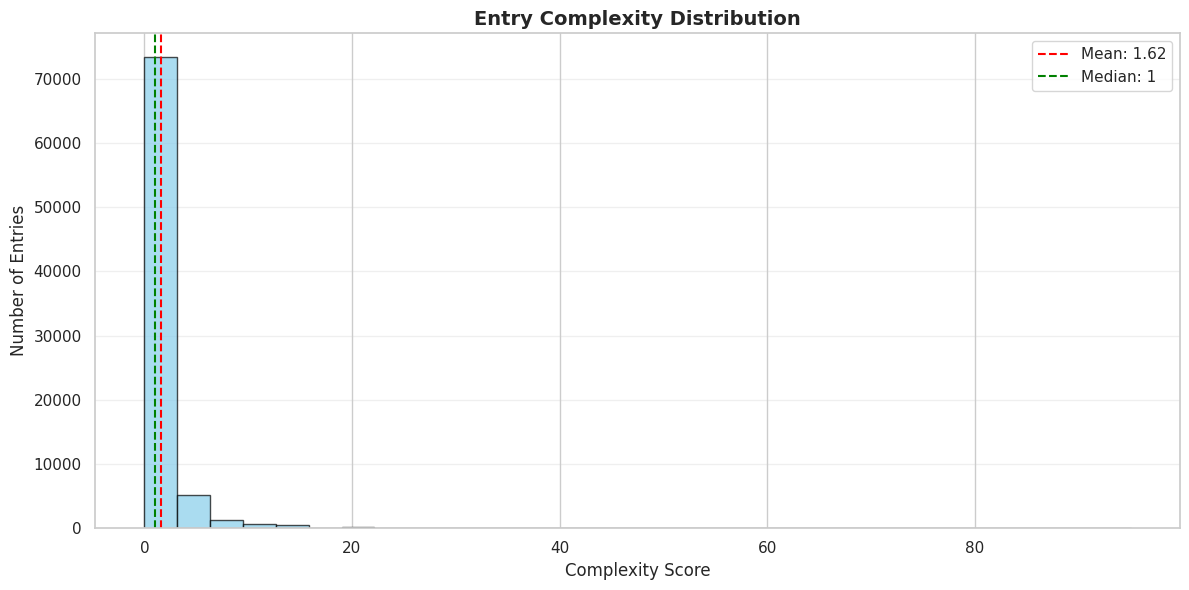

In [22]:
# Complexity histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(entries_df['complexity'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax.axvline(entries_df['complexity'].mean(), color='red', linestyle='--', 
           label=f'Mean: {entries_df["complexity"].mean():.2f}')
ax.axvline(entries_df['complexity'].median(), color='green', linestyle='--', 
           label=f'Median: {entries_df["complexity"].median():.0f}')
ax.set_xlabel('Complexity Score')
ax.set_ylabel('Number of Entries')
ax.set_title('Entry Complexity Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Summary Statistics Export

In [23]:
# Create summary report
summary = {
    'analysis_date': datetime.now().isoformat(),
    'total_pages': len(df),
    'total_entries': len(entries_df),
    'unique_artists': df['root_artist'].nunique(),
    'standard_match_rate': float(match_rate),
    'platform_distribution': {k: int(v) for k, v in platform_counts.items()},
    'template_usage': {k: int(v) for k, v in templates.items()},
    'status_markers': {k: int(v) for k, v in status_markers.items()},
    'feat_stats': {
        'entries_with_feat': int(len(entries_with_feat)),
        'max_feat_count': int(entries_df['feat_count'].max()),
        'avg_feat_count': float(entries_with_feat['feat_count'].mean()) if len(entries_with_feat) > 0 else 0,
    },
    'complexity_stats': {
        'mean': float(entries_df['complexity'].mean()),
        'median': float(entries_df['complexity'].median()),
        'std': float(entries_df['complexity'].std()),
        'max': int(entries_df['complexity'].max()),
    },
}

# Save summary
summary_path = PROJECT_ROOT / 'data' / 'processed' / 'analysis_summary.json'
summary_path.parent.mkdir(parents=True, exist_ok=True)
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"✅ Summary saved to: {summary_path}")
print()
print("=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)
print(f"Total entries analyzed: {len(entries_df):,}")
print(f"Standard pattern match rate: {match_rate:.1f}%")
print(f"Estimated LLM workload: {(100-match_rate):.1f}% ({(~entries_df['matches_standard']).sum():,} entries)")
print()
print("Next step: Build regex parser in 03_parser_development.ipynb")

✅ Summary saved to: /home/akkun/utaitewiki-songlist-migration/data/processed/analysis_summary.json

ANALYSIS COMPLETE
Total entries analyzed: 81,542
Standard pattern match rate: 95.7%
Estimated LLM workload: 4.3% (3,539 entries)

Next step: Build regex parser in 03_parser_development.ipynb
